# Import Libraries

In [52]:
import pandas as pd
import numpy as np
# For text cleaning
import re
import nltk
from nltk.corpus import stopwords #for stopword removal
from nltk.stem import WordNetLemmatizer #for lemmatization
from nltk.corpus import wordnet
# For data splitting
from sklearn.model_selection import train_test_split
# For tokenizing and padding
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
# For simple dense model building
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense, Dropout
from scikeras.wrappers import KerasClassifier
# for recurrent neural network model building
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense
# For model evaluation
from sklearn.metrics import classification_report
# For plotting
import matplotlib.pyplot as plt;
# for grid search
import itertools

# Dataset Preparation

We are only interested in the following columns:
- choose_one: target variable, whether tweet is about an actual disaster or not
- text: the tweet
- keyword: keyword from the tweet, potential train variable
- location: where tweet was sent form, potential train variable

In [5]:
# Read in data
df = pd.read_csv("socialmedia-disaster-tweets-DFE.csv")

In [7]:
# Filter for relevant columns
data = df[['choose_one', 'text', 'keyword', 'location']]

# Change column names
data.columns = ['disaster', 'tweet', 'keyword', 'location']

# Remove 'Can't Decide' rows
data = data[data['disaster'] != "Can't Decide"]

# Drop NA rows
data = data.dropna(subset=['disaster', 'tweet'])

# One-Hot encode 'disaster' column
data['disaster'] = data['disaster'].replace({"Relevant": 1, "Not Relevant": 0})

data.head()

/var/folders/0_/l4s85yyx0nq0sr3jrhhw7n740000gn/T/ipykernel_13638/1314727611.py:14: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data['disaster'] = data['disaster'].replace({"Relevant": 1, "Not Relevant": 0})


,disaster,tweet,keyword,location
0,1,Just happened a terrible car crash,NaN,NaN
1,1,Our Deeds are the Reason of this #earthquake M...,NaN,NaN
2,1,"Heard about #earthquake is different cities, s...",NaN,NaN
3,1,"there is a forest fire at spot pond, geese are...",NaN,NaN
4,1,Forest fire near La Ronge Sask. Canada,NaN,NaN


# Data Preprocessing

## Data Cleaning

In [12]:
# Get English stop words
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Create lemmatizer
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/andrewfox/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/andrewfox/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [14]:
def clean(text, stopwords=False, lemmatize=False):
    text = re.sub(r'https?://\S+|www\.\S+', '', text).strip() #remove links like https://
    text = text.lower()                                       #lowercase all characters
    text = text.strip()                                       #string white space
    text = re.sub(r'[^a-z\s]', ' ', text)                     #replace special characters with a whitespace
    text = re.sub(r'\s+', ' ', text).strip()                  #remove double white spaces

    # remove stop words if specified
    if stopwords == True:
        text = ' '.join(word for word in text.split() if word.lower() not in stop_words)

    # lemmatize if specified
    if lemmatize == True:
        text = ' '.join(lemmatizer.lemmatize(word) for word in text.split()) #lemmatize nouns if specified
        text = ' '.join(lemmatizer.lemmatize(word, pos=wordnet.VERB) for word in text.split()) #lemmatize verbs if specified
        
    return text

# Test clean() function
def clean_test(num, stopwords=False, lemmatize=False):
    sentence = data['tweet'][num]
    print("Original Sentence:")
    print(sentence)
    print()
    print("Cleaned Sentence:")
    print(clean(sentence, stopwords, lemmatize))

In [16]:
clean_test(100, False, False)

Original Sentence:
http://t.co/GKYe6gjTk5 Had a #personalinjury accident this summer? Read our advice &amp; see how a #solicitor can help #OtleyHour

Cleaned Sentence:
had a personalinjury accident this summer read our advice amp see how a solicitor can help otleyhour


### Splitting data

In [22]:
def features_target():
    X = data["tweet"].astype(str) #define features
    y = data["disaster"]          #define target
    return X, y

X, y = features_target()

# Clean data
X = X.apply(clean, stopwords=False, lemmatize=False)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### Tokenizing data

Because we have to pad tweets so that they are all of the same size for the neural network, it is important to find a max length to which they will be filled to, as we don't want to pad shorter sentences with a bunch of 0s. Looking at the length of tweets in the dataset can help decide this value. We look at the 95th percentile of tweet lengths.

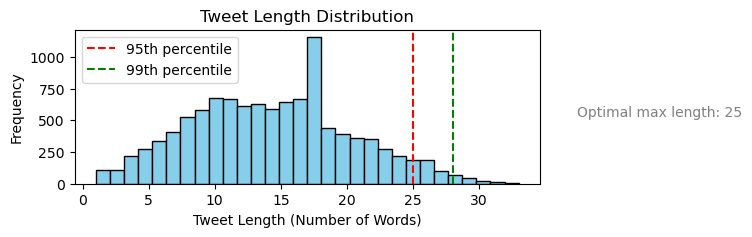

In [25]:
# Find length of tweets
tweet_lengths = X.astype(str).apply(lambda x: len(x.split()))
percentile_95 = int(np.percentile(tweet_lengths, 95))  # 95th percentile of tweet lengths

# Plot histogram
plt.figure(figsize=(6, 2))
plt.hist(tweet_lengths, bins=30, color="skyblue", edgecolor="black")
plt.axvline(np.percentile(tweet_lengths, 95), color='red', linestyle='dashed', label="95th percentile")
plt.axvline(np.percentile(tweet_lengths, 99), color='green', linestyle='dashed', label="99th percentile")
plt.xlabel("Tweet Length (Number of Words)")
plt.ylabel("Frequency")
plt.title("Tweet Length Distribution")
plt.suptitle(f"Optimal max length: {percentile_95}", fontsize=10, color="gray", y=0.5, x=1.1)
plt.legend()
plt.show()

The maximum tweet length is not significantly longer than 25, so a max length can be set at 30.

In [28]:
MAX_LEN = 30
def tokenize(X_train, x_test, MAX_LEN):
    tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
    tokenizer.fit_on_texts(X_train)  # Fit only on training data

    # Convert text to numerical sequences
    X_train_seq = tokenizer.texts_to_sequences(X_train)
    X_test_seq = tokenizer.texts_to_sequences(X_test)
    
    # Pad sequences to of same shape, using max length determined before
    X_train_padded = pad_sequences(X_train_seq, maxlen=MAX_LEN, padding='post', truncating='post')
    X_test_padded = pad_sequences(X_test_seq, maxlen=MAX_LEN, padding='post', truncating='post')

    return X_train_padded, X_test_padded

# Models

## Simple Dense Neural Network

In [32]:
def create_model(X_train, y_train, X_test, y_test, input_dim, output_dim, layers, 
                activation='relu', optimizer='adam', epochs=10, batch_size=32):
    
    model = Sequential()
    model.add(Embedding(input_dim=input_dim, output_dim=output_dim))  # Embedding layer
    model.add(Flatten())

    # Add layers dynamically
    for units in layers:
        model.add(Dense(units, activation=activation))

    # Output layer for binary classification
    model.add(Dense(1, activation='sigmoid'))

    # Compile the model
    model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=['accuracy'])

    # Train the model
    model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=batch_size, verbose=0)

    return model

In [34]:
def evaluate_model(model):
    test_loss, test_acc = model.evaluate(X_test, y_test)
    y_pred = (model.predict(X_test) > 0.5).astype("int32") # Convert probabilities to binary labels
    print(classification_report(y_test, y_pred))

### Determining the best cleaning parameters

I will build and evaluate a simple dense neural network model trying different text cleaning (that is, with and without stopword removal, and with and without lemmatization) to see which permutation works best.

In [49]:
print("-----------------------------------------------------------------------")
print("NO stopword removal, NO lemmatization")
print("-----------------------------------------------------------------------")
X, y = features_target()
X = X.apply(clean, stopwords=False, lemmatize=False)                                      #clean data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42) #split data
X_train, X_test = tokenize(X_train, X_test, MAX_LEN)                                      #tokenize
model = create_model(X_train, y_train, X_test, y_test, 10000, 16, layers=[32])
evaluate_model(model)

print("-----------------------------------------------------------------------")
print("stopword removal, NO lemmatization")
print("-----------------------------------------------------------------------")
X, y = features_target()
X = X.apply(clean, stopwords=True, lemmatize=False)                                       #clean data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42) #split data
X_train, X_test = tokenize(X_train, X_test, MAX_LEN)                                      #tokenize
model = create_model(X_train, y_train, X_test, y_test, 10000, 16, layers=[32])
evaluate_model(model)


print("-----------------------------------------------------------------------")
print("NO stopword removal, lemmatization")
print("-----------------------------------------------------------------------")
X, y = features_target()
X = X.apply(clean, stopwords=False, lemmatize=True)                                       #clean data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42) #split data
X_train, X_test = tokenize(X_train, X_test, MAX_LEN)                                      #tokenize
model = create_model(X_train, y_train, X_test, y_test, 10000, 16, layers=[32])
evaluate_model(model)


print("-----------------------------------------------------------------------")
print("stopword removal, lemmatization")
print("-----------------------------------------------------------------------")
X, y = features_target()
X = X.apply(clean, stopwords=True, lemmatize=True)                                        #clean data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42) #split data
X_train, X_test = tokenize(X_train, X_test, MAX_LEN)                                      #tokenize
model = create_model(X_train, y_train, X_test, y_test, 10000, 16, layers=[32])
evaluate_model(model)

-----------------------------------------------------------------------
NO stopword removal, NO lemmatization
-----------------------------------------------------------------------
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7479 - loss: 0.7587
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
              precision    recall  f1-score   support

           0       0.78      0.80      0.79      1830
           1       0.74      0.72      0.73      1428

    accuracy                           0.77      3258
   macro avg       0.76      0.76      0.76      3258
weighted avg       0.77      0.77      0.77      3258

-----------------------------------------------------------------------
stopword removal, NO lemmatization
-----------------------------------------------------------------------
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7556 - loss: 0.7674
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
              precision    recall  f1-score   support

           0       0.77  

It seems there is no significant effect of stopword removal and/or lemmatization on model performance. Therefore, no stopword removal nor lemmatization will be done in building models. 

## Hyperparameter Tuning Models

Here I do a simple grid search to perform hyperparameter tuning. Previous attempts at this revealed 'sgd' optimizer performs significantly worse than 'adam', and so the latter will always be used.

In [55]:
def grid_search(X_train, y_train, X_test, y_test, param_grid):
    # Generate all possible parameter combinations
    keys, values = zip(*param_grid.items())
    param_combinations = list(itertools.product(*values))

    for params in param_combinations:
        param_dict = dict(zip(keys, params))

        print(f"\nTraining with parameters: {param_dict}")

        model = create_model(
            X_train, y_train, X_test, y_test,
            input_dim=10000, 
            output_dim=16,
            layers=[param_dict['layers']],
            activation=param_dict['activation'],
            optimizer='adam',
            epochs=param_dict['epochs'],
            batch_size=32
        )

        evaluate_model(model)

In [57]:
X, y = features_target()
X = X.apply(clean, stopwords=True, lemmatize=True)                                        #clean data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42) #split data
X_train, X_test = tokenize(X_train, X_test, MAX_LEN)                                      #tokenize

In [59]:
param_grid = {
    'activation': ['relu', 'tanh'],
    'layers': [16, 32, 64],
    'epochs': [10, 20]
}

grid_search(X_train, y_train, X_test, y_test, param_grid)


Training with parameters: {'activation': 'relu', 'layers': 16, 'epochs': 10}
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7626 - loss: 0.7622
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
              precision    recall  f1-score   support

           0       0.78      0.83      0.81      1830
           1       0.76      0.71      0.73      1428

    accuracy                           0.78      3258
   macro avg       0.77      0.77      0.77      3258
weighted avg       0.77      0.78      0.77      3258


Training with parameters: {'activation': 'relu', 'layers': 16, 'epochs': 20}
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7435 - loss: 0.8244
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
              precision    recall  f1-score   support

           0       0.78      0.80      0.79      1830
           1       0.73      0.72      0.72      1428

    accuracy                           0.76      3258
   macro avg       0.76      0.76      0.76      3258
weighted avg 

The best performing model had parameters:

{'activation': , 'layers': , 'epochs':}

which achieved an accuracy of 78% and an f1-score of 0.81 for 0 and 0.73 for 1.

# Recurrent Neural Network (RNN)
I will now build a recurrent neural network. For simplicity's sake, the best performing parameters from the simple dense model will be used.

In [132]:
def rnn_model(input_dim, output_dim, rnn_units=64, activation='relu', optimizer='adam'):
    model = Sequential([
        Embedding(input_dim=input_dim, output_dim=output_dim),
        SimpleRNN(rnn_units, activation='relu'),
        Dense(1, activation='sigmoid')
    ])

    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

In [134]:
model = rnn_model(10000, 16, rnn_units=64)
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=32, verbose=0)

In [136]:
evaluate_model(model)

102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7603 - loss: 1.8040
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
              precision    recall  f1-score   support

           0       0.77      0.84      0.80      1830
           1       0.77      0.67      0.72      1428

    accuracy                           0.77      3258
   macro avg       0.77      0.76      0.76      3258
weighted avg       0.77      0.77      0.77      3258

